# Cloud Segmentation with Meteors

This tutorial demonstrates how to use the `meteors` package to explain and interpret remote sensing models for segmentation tasks. Specifically, we'll focus on cloud segmentation in multispectral satellite imagery, where the model classifies each pixel as:
- clear (terrain) 
- Thick cloud
- Thin cloud
- Cloud shadow

We'll be using the `UNetMobV2_V1` model, which is based on research presented in the paper [CloudSEN12: A Global Dataset for Semantic Understanding of Cloud and Cloud Shadow in Sentinel-2]([paper_link](https://www.nature.com/articles/s41597-022-01878-2)).


**Note:** Before starting this tutorial, ensure you have installed the latest version of `meteors` from PyPI, which includes most required dependencies:

```bash
pip install meteors
```

Downloaded the `cloudsen12_models` module from our examples repository. This module contains essential preprocessing utilities and model loading functions. You can download it directly from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/segmentation).

## Table of Contents
- [1. Loading the Model](#1-loading-the-model)
- [2. Loading Sample Images](#loading-sample-images)
- [3. Interpreting the Model](#3-interpreting-the-model)
  - [3.1. Interpreting the Model with LIME](#31-interpreting-the-model-with-lime)
  - [3.2. Interpreting the Model with Gradient Methods](#32-interpreting-the-model-with-gradient-methods)

## 1. Loading the Model

We'll use a modified version of the `UNetMobV2_V1` model from the `cloudsen12_models` module. This implementation has been adapted to:
- Work seamlessly with PyTorch inputs and outputs
- Reduce external dependencies
- Maintain the original model architecture and performance

The code is sourced from this repo: [cloudsen12_models](https://github.com/Fersoil/cloudsen12_models/) repository.


In [1]:
from cloudsen12_models import cloudsen12
import numpy as np
import matplotlib.pyplot as plt
import meteors as mt
import torch

import meteors.visualize as vis

In [ ]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")
cloudsen12_segment_interpretation = ["clear", "Thick cloud", "Thin cloud", "Cloud shadow"]

## 2. Loading Sample Images

For this tutorial, we'll use preprocessed Sentinel-2 imagery ready for cloud segmentation. The metadata of the image is as follows:
- **Collection:** COPERNICUS/S2_HARMONIZED
- **Tile ID:** S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941
- **Source Platform:** Google Earth Engine (GEE)

The imagery has been preprocessed following the workflow detailed in [this reference notebook](https://github.com/IPL-UV/cloudsen12_models/blob/main/notebooks/run_in_gee_image.ipynb). This ensures the data meets the model's requirements.

In [9]:
img = np.load("data/0.npz")["img"]

sentinel_central_wavelengths = [
    442.7,
    492.4,
    559.8,
    664.6,
    704.1,
    740.5,
    782.8,
    832.8,
    864.7,
    945.1,
    1373.5,
    1613.7,
    2202.4,
]

The Meteros package provides an easy-to-use wrapper for `HSI` hyperspectral images. To take full advantage of the wrapper's potential, we also need to include wavelengths of the object. 

The `HSI` data object can be easily visualized in RGB format.

In [10]:
hsi = mt.HSI(image=img, wavelengths=sentinel_central_wavelengths)

The original image is stored in the `image` attribute of the `HSI` object. Let's now test that the model can predict cloud segmentation on this image.

In [ ]:
cloudmask = model.predict(
    hsi.image.unsqueeze(0)
)
cloudmask_hard_labels = torch.argmax(cloudmask, dim=1).type(torch.uint8)

The model output is a 4-channel tensor, where each channel represents a different class (soft labels). To get the final prediction, we need to use the `argmax` function to select the class with the highest probability.

In [12]:
cloudmask_hard_labels.shape

torch.Size([1, 622, 916])

Let's now visualize the model's prediction on the image.

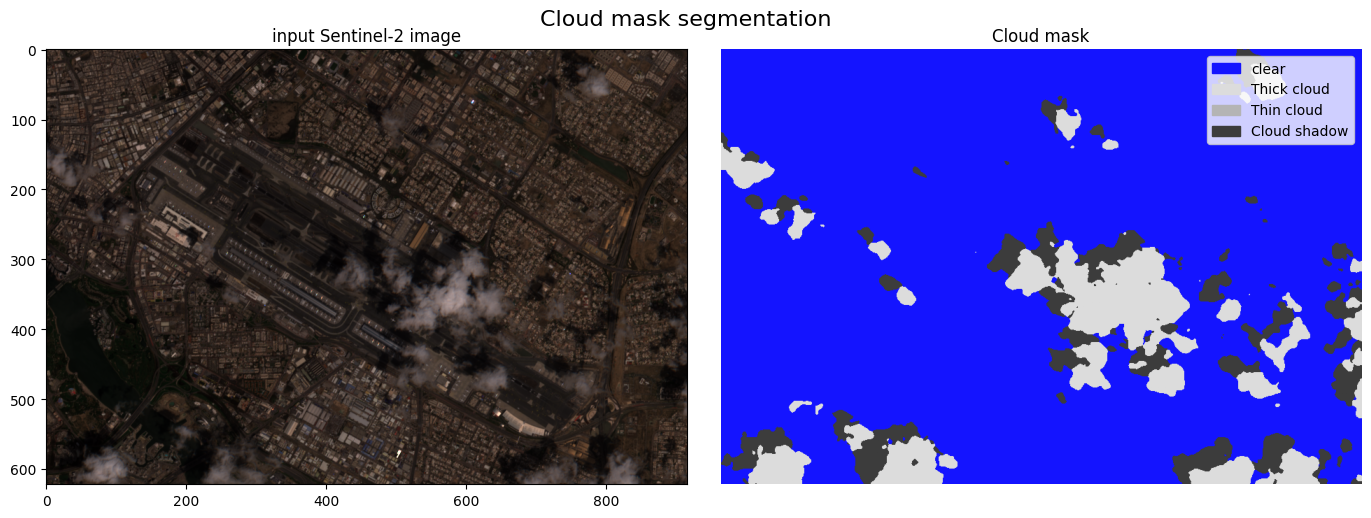

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels.squeeze(), ax[1])
ax[1].set_title("Cloud mask")

vis.visualize_hsi(hsi, ax[0])
ax[0].set_title("input Sentinel-2 image")
fig.suptitle("Cloud mask segmentation", fontsize=16)

plt.show()

## 3 Interpreting the Model

The `meteors` package's XAI methods for now are designed for single-output analysis (classification or regression). However, segmentation models produce multi-dimensional outputs (predictions for each pixel). To bridge this gap, we need to convert our segmentation problem into a regression task using a simple trick - aggregation.

Instead of analyzing individual pixel predictions, we'll aggregate them by region to produce a single numerical output. This is done by getting the model's pixel-wise predictions and counting the pixels in each class. The `meteors` package provides a simple aggregation function `agg_segmentation_postprocessing` for this purpose, but you can experiment with other aggregation functions as well.

In [14]:
from meteors.utils import agg_segmentation_postprocessing

postprocessing = agg_segmentation_postprocessing(
    soft_labels=True,  # the model outputs probability of each class
    classes_numb=len(cloudsen12_segment_interpretation),  # our model outputs 4 classes
    class_axis=1,
)

The `agg_segmentation_postprocessing` function requires several parameters to properly handle different model outputs. Let's examine each parameter in detail:
- `soft_labels` parameter specifies whether the analysed model outputs soft labels (probabilities of pixels belonging to each class) or hard labels (one class is assigned for each pixel). In case the model uses hard labels, the shape of the output should be 3 dimensional, with batch size as its first dimension. The output's shape should be 4 dimensional otherwise
- `classes_numb` is a parameter specifying how many classes are predicted by the model
- `class_axis` used only for soft labels. It specifies on which axis the class dimension is. If the `class_axis` equals to 0, then batch size should be at the second dimension.

Let's now use the `agg_segmentation_postprocessing` function to convert the model's output into a single numerical output. We'll then use this output to interpret the model with meteors' XAI methods.

In [ ]:
aggregated_segmentation_mask = postprocessing(cloudmask)
aggregated_segmentation_mask

tensor([[461402.5625,  50634.7188,      0.0000,  33250.5391]],
       grad_fn=<SumBackward1>)

In [16]:
cloudmask.shape

torch.Size([1, 4, 622, 916])

In [17]:
aggregated_segmentation_mask.shape

torch.Size([1, 4])

Text(0.5, 0, 'Class')

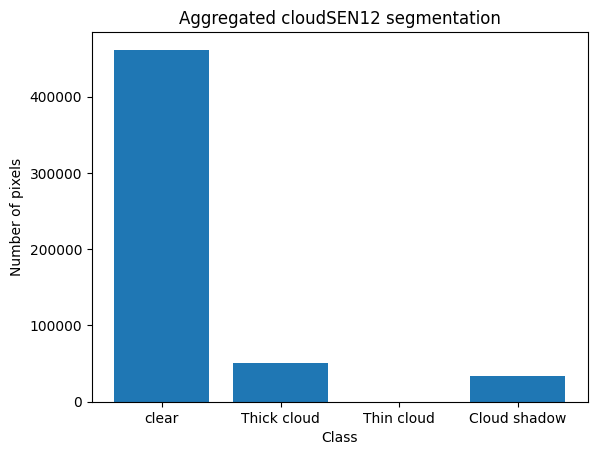

In [18]:
plt.bar(np.arange(4), aggregated_segmentation_mask.detach().squeeze())
plt.xticks(np.arange(4), cloudsen12_segment_interpretation)
plt.title("Aggregated cloudSEN12 segmentation")
plt.ylabel("Number of pixels")
plt.xlabel("Class")

The `agg_segmentation_postprocessing` function is used to aggregate the model's pixel-wise predictions into a single numerical output. One thing to note is that the sum of the aggregated values is not necessarily equal to the number of pixels in the image. This is because the aggregation function takes the probabilities of the argmax class for each pixel and sums them up. 

Now that we tested how to aggregate the model's output, we can proceed with the explanation. One last thing is to properly initialize the model inside the `meteors` environment. This is done by creating an object that contains all the necessary information to perform an explanation, which is:
- the forward function of the model
- the problem type, here `segmentation`
- in case the problem type is `segmentation`, the required parameter is the `postprocessing_output`, which is a method for aggregating the outputs as we did before.

In [19]:
explainable_model = mt.models.ExplainableModel(
    model.predict, problem_type="segmentation", postprocessing_output=postprocessing
)

And let's check that model forward function now returns the aggregated output with the gradients.

In [20]:
aggregated_segmentation_mask = explainable_model(hsi.image.unsqueeze(0))
aggregated_segmentation_mask

tensor([[461402.5625,  50634.7188,      0.0000,  33250.5391]],
       grad_fn=<SumBackward1>)

### 3.1 Interpreting the Model with LIME

We'll use the [LIME (Local Interpretable Model-agnostic Explanations)](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) method to understand our model's behavior. For a comprehensive understanding of LIME and its implementation in `meteors`, refer to our [LIME tutorial](https://xai4space.github.io/meteors/latest/tutorials/lime/).

The intepretable model of LIME is a linear model lasso model with a regularization parameter of 0.001.

In [ ]:
interpretable_model = mt.models.SkLearnLasso(alpha=0.001)
lime = mt.attr.Lime(explainable_model=explainable_model, interpretable_model=interpretable_model)

#### Spatial analysis

First, we'll analyze which image regions most significantly influence the model's predictions. LIME requires a spatial segmentation mask that specifies how the image is divided into interpretable regions.
We will use the `SLIC` algorithm to generate this mask. The `SLIC` algorithm is a superpixel segmentation method that groups pixels into regions based on their similarity.

**Note:** This LIME segmentation mask is distinct from our cloud segmentation model's output - it's used solely to help LIME identify relevant image regions.

In [ ]:
lime_seg_mask = lime.get_segmentation_mask(hsi, segmentation_method="slic", num_interpret_features=50)
attributes = lime.get_spatial_attributes(
    hsi,  # input image
    target=0, # target=0 means we want to explain the first class, which is "clear"
    segmentation_mask=lime_seg_mask # segmentation mask
)

2024-11-13 16:40:02.650 | WARNING  | meteors.attr.explainer:device:143 - Not a torch model, setting device to cpu


And let's now visualize the LIME spatial explanation.

Score of the attribution: 1.0


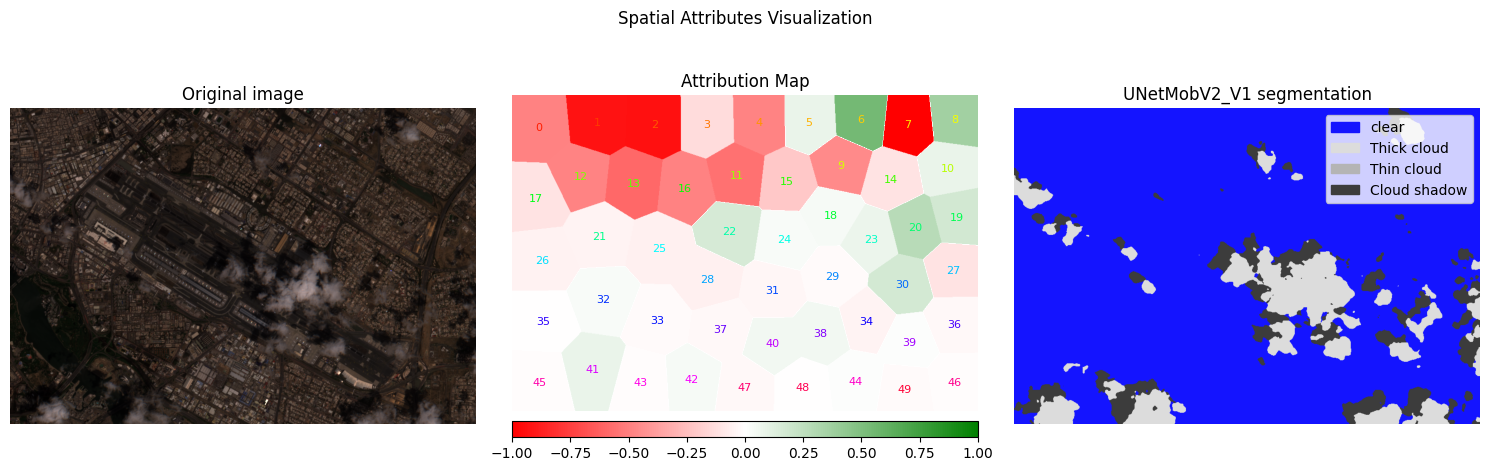

In [23]:
fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
print(f"Score of the attribution: {attributes.score}")
fig.tight_layout()
plt.show()

The figure above is a slight modification of the baseline figure provided by the `meteors` pacakge, which summarizes the spatial analysis for a specific image. 

The colors in the attribution map, presented in the center, have the following meaning:
- **Red**: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class `0` (clear terrain).
- **White**: This segment did not have a significant impact on the output.
- **Green**: This superpixel is positively correlated with the output. Its presence increases the value for the class `0`.

The score that we printed is the `R2` score of the LIME interpretable model. It is a measure of how well the interpretable model approximates the original model. The closer the score is to 1, the better the approximation.

As we can see in the figure above, the most relevant regions are in the top of the input image.

Score of the attribution: 1.0


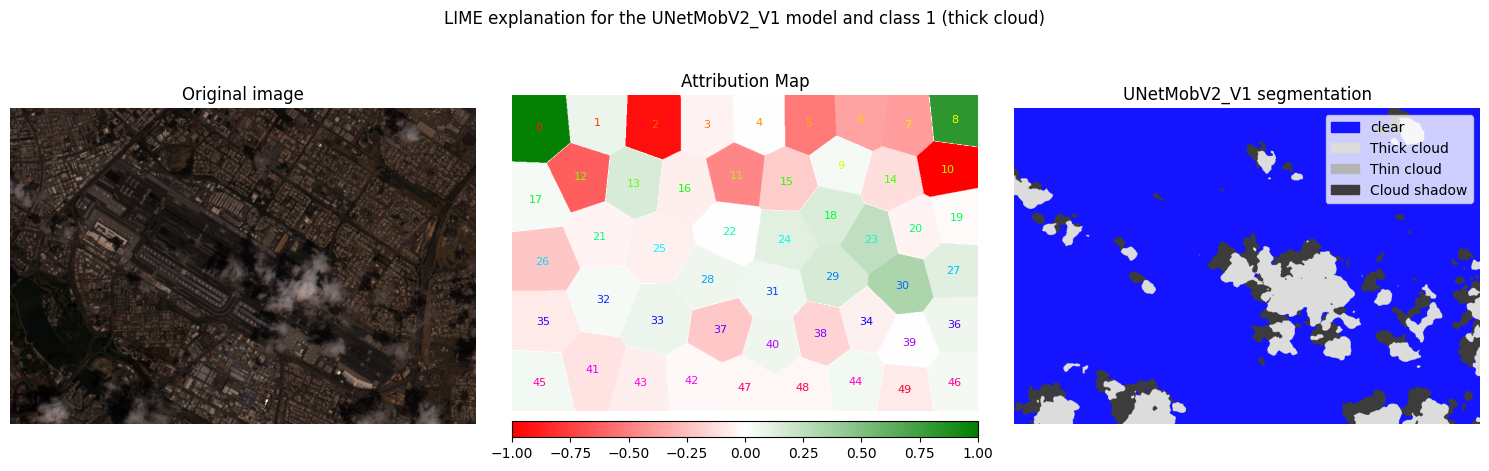

In [25]:
attributes = lime.get_spatial_attributes(hsi, target=1, segmentation_mask=lime_seg_mask, num_samples=100)

fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
print(f"Score of the attribution: {attributes.score}")
fig.tight_layout()
plt.show()

For the class thick cloud, the situation is very similar. Again the regions from the top of the image seems to be the most relevant for the model.

### Spectral analysis

Now, we will perform spectral analysis, which focuses on different bands and their impact on the models predictions. For the multispectral images, we can analyse the impact of all the bands seperately, or group them into superbands. Firstly, let's investigate, which of the bands are the most important.

To do so, we will need to create a band mask - a similar object to the lime segmentation mask, but with aggregations in the spectral dimension.

In [ ]:
band_indices = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B10": 10,
    "B11": 11,
    "B12": 12,
}

band_mask, band_names = lime.get_band_mask(hsi, band_indices=band_indices)
attributes = lime.get_spectral_attributes(hsi, target=0, band_mask=band_mask, band_names=band_names)

Once the attributions are calculated, we can easily visualize them as previously but now focusing on the spatial explanations.

Score of the attribution: 1.0


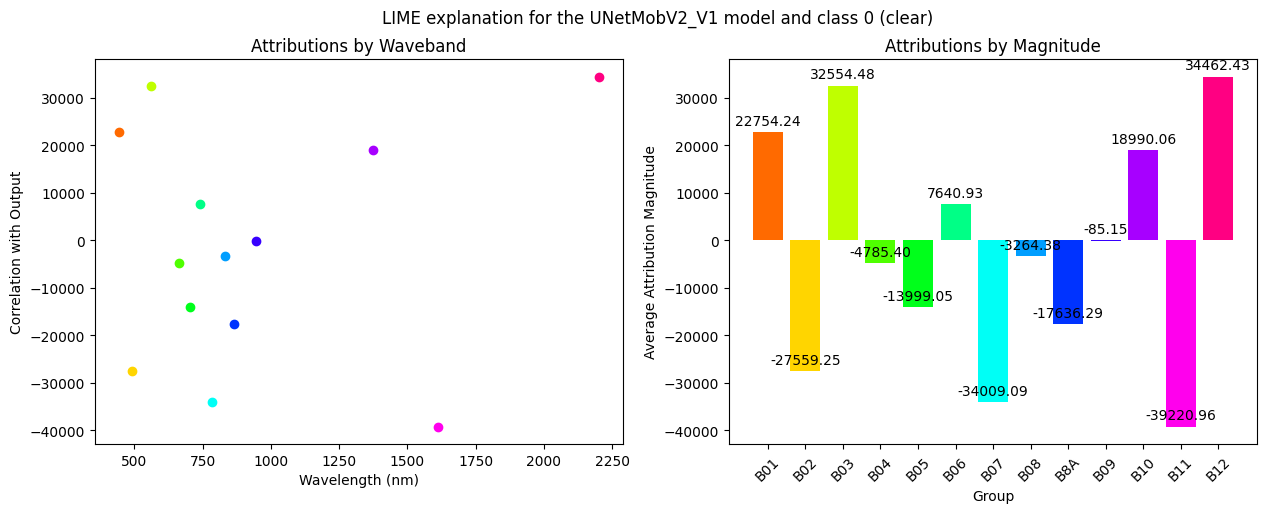

In [27]:
mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 0 (clear)")
plt.show()

In the chart above, we can see which of the specified bands contribute the most to the model's prediction. On the left, we can exactly see the correlation with the output and the bands wavelenghts, whereas plot on the right allows to easily compare the attribution values. 

As we can see, the most important bands for segmentatating the clear sky regions are bands number 4 and 6. In fact, the bands B11, B08 and B04 are used usually to segment the clouds using the standard non=machine learning approach. 

Similarily, as in the case of the spatial explanations, we can also analyse easily different classes, by passing a different target value to the function.

In [ ]:
attributes = lime.get_spectral_attributes(
    hsi,
    target=1,  # thick cloud
    band_mask=band_mask,
    band_names=band_names,
    n_samples=200,
    perturbations_per_eval=20,
)

mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
plt.show()

### 3.2. Interpreting the Model with Gradient Methods

To further understand the model's behavior, we can use gradient-based methods to analyze how the model's predictions change with respect to the input image. These methods provide a pixel-wise attribution of the model's output, showing which pixels are most influential in the model's decision-making process. Integrated Gradients method is a powerful gradient-based attribution technique, for detailed background, refer to the [original paper](https://doi.org/10.48550/arXiv.1703.01365).
<!-- or our comprehensive [attribution methods guide](https://xai4space.github.io/meteors/latest/tutorials/attribution_methods/). -->


In [ ]:
ig = mt.attr.IntegratedGradients(explainable_model=explainable_model)
attributes = ig.attribute(hsi, target=0, n_steps=10)

Text(0.5, 0.98, 'Integrated Gradient explanation for the UNetMobV2_V1 model and class 0 (clear)')

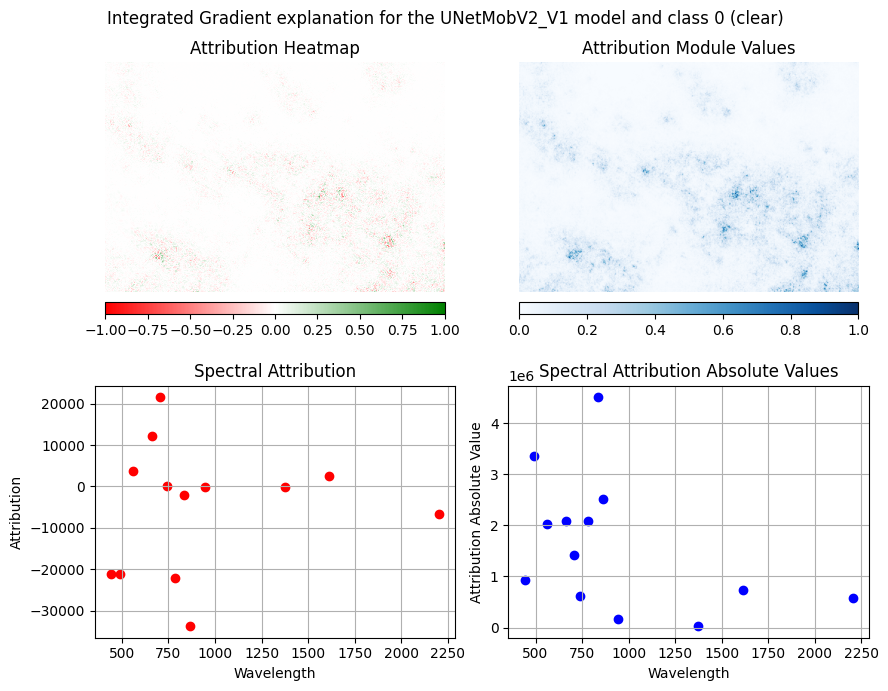

In [ ]:
fig, ax = vis.visualize_attributes(attributes)
print(f"Convergence of the integrated gradients: {attributes.score}")
fig.suptitle("Integrated Gradient explanation for the UNetMobV2_V1 model and class 0 (clear)")

The attribution visualization provides two complementary perspectives on model behavior:

**Top Images - Spatial Attribution**
- Shows spatialy which regions in the image influence model predictions
- Helps identify areas crucial for detecting specific features (e.g., cloud edges or clear sky)
- Intensity indicates strength of influence on the prediction

**Bottom Images - Spectral Attribution**
- Reveals which spectral bands are most important for predictions
- Highlights bands that provide strong cloud/ground contrast
- Helps understand which wavelengths are key for feature discrimination

The similar attributions can be calculated for another class - cloud shadow.

Text(0.5, 0.98, 'Integrated Gradient explanation for the UNetMobV2_V1 model and class 3 (cloud shadow)')

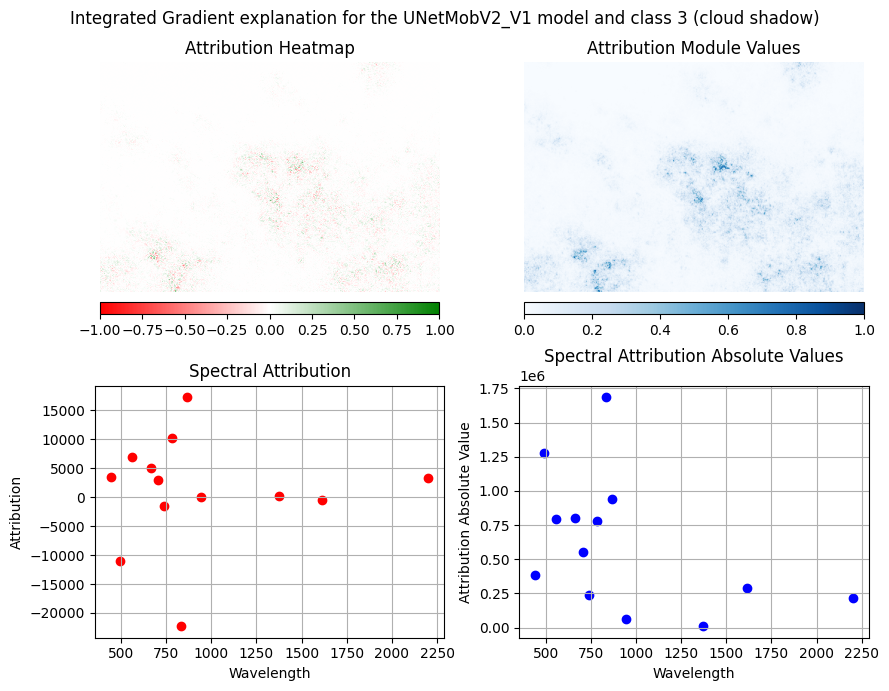

In [ ]:
attributes = ig.attribute(hsi, target=3, n_steps=10)
print(f"Convergence of the integrated gradients: {attributes.score}")
fig, ax = vis.visualize_attributes(attributes)
fig.suptitle("Integrated Gradient explanation for the UNetMobV2_V1 model and class 3 (cloud shadow)")

Looking at the attribution map for class 3 (cloud shadow), we can observe a strong correlation between areas of actual cloud shadows in the original image and regions of high attribution values. Additionaly we see that spectraly the most important bands are the first ones, wheras the further bands are not as important.
